<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima statsmodels scikit-learn

In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta  # Para calcular data de um ano atrás
from typing import Literal # Para anotação dos argumentos de funções
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

In [4]:
class DataLoader:
  '''
  Esta classe carrega dos dados de precificação de ativos e os coloca em um
  mesmo padrão a ser usado em todo o projeto, qual seja, um DataFrame com a
  seguinte estrutura:
    #   Column     Dtype            Descrição
    ---  ------    -----            ---------
    0   ds         datetime64[ns]   Data da observação
    1   y          float64          Observação (variável alvo)
    2   unique_id  str              Identificador da série temporal

  '''
  FREQ_VALUES = ['d', 'W','ME','Q','y']

  @staticmethod
  def stand(df: pd.DataFrame, symbol:str, col_ds='date', col_y='close', value_id=None) -> pd.DataFrame:
    '''
    Esta função padroniza o DataFrame para que fique
    no formato esperado pelo restante deste notebook.
    '''

    # Garantir que "date" seja uma coluna normal
    df = df.reset_index()
    # Converter nomes das colunas para minúsculas
    df.columns = df.columns.str.lower()
    col_ds = col_ds.lower()
    col_y = col_y.lower()
    # Padronizando no nome das colunas
    df.drop(columns=df.columns.difference([col_ds, col_y]), inplace=True)

    df.rename(columns={col_ds: 'ds', col_y: 'y'}, inplace=True)

    df['y'] = df['y'].astype(float)
    # Converter a coluna 'ds' para datetime, caso não esteja nesse formato
    df['ds'] = pd.to_datetime(df['ds'])

    df['unique_id'] = symbol if value_id is None else value_id
    # Convertendo a coluna 'coluna' para string
    df['unique_id'] = df['unique_id'].astype(str)
    return df


  # Carregar dados a partir do sistema de arquivos
  def from_csv(self, path, symbol='ativo', col_ds='ds', col_y='y', value_id='ativo', delimiter=',', decimal='.', dayfirst=False):
      df = pd.read_csv(path, parse_dates=[col_ds], index_col=col_ds, delimiter=delimiter, decimal=decimal, dayfirst=dayfirst)
      df = self.stand(df, symbol=symbol, col_ds=col_ds, col_y=col_y, value_id=value_id)

      return df

  # Carregar os dados a partir do Yahoo Finance.
  class __YahooFinance:
    @staticmethod
    def get(symbol:str, start_date:datetime, end_date:datetime = None) -> DataFrame:
      '''
      Esta função carrega os dados diários de um ativo a partir do Yahoo Finance.
      '''
      import yfinance as yf
      df = yf.download(tickers=symbol, start=start_date, end=end_date)
      # Garantir que as colunas não sejam MultiIndex
      if isinstance(df.columns, pd.MultiIndex):
          # Remove o segundo nível do MultiIndex,
          # pois ele contém apenas o símbolo do ativo,
          # não acrescentando valor semântico aqui,
          # já que só trabalhamos com um ativo por vez.
          df = df.droplevel(1, axis=1)
      # Remove o nome do MultiIndex ("Price")
      df.columns.name = None

      return df

  def from_yahoo(self, symbol:str, start_date:datetime, end_date:datetime = None, col_y='close', value_id=None) -> DataFrame:
    df = self.__YahooFinance.get(symbol=symbol, start_date=start_date, end_date = end_date)
    df = self.stand(df, symbol=symbol, col_y=col_y, value_id=value_id)

    return df


  @staticmethod
  def infer_freq(df:pd.DataFrame) -> str:
    """
    Infere a frequência dos dados com base na diferença mais comum entre as datas.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo uma coluna de datas.

    Retorna:
    str: Frequência inferida ('d', 'W', 'ME', 'Q', 'y').

    Lança:
    ValueError: Se não for possível inferir a frequência.
    """
    if 'y' not in df.columns:
        raise ValueError(f"A coluna 'y' não existe no DataFrame.")

    if 'ds' not in df.columns:
        raise ValueError(f"A coluna 'ds' não existe no DataFrame.")

    # Verifica se a coluna é do tipo datetime
    if df['ds'].dtype != 'datetime64[ns]':
        raise ValueError(f"A coluna 'ds' não é do tipo datetime64: {df['ds'].dtype}")

    # Calcular a diferença entre datas consecutivas
    dias = df['ds'].dropna().diff().mode()[0].days

    if dias == 1:
        return 'd'  # Diário
    elif dias == 7:
        return 'W'  # Semanal
    elif dias in [28, 29, 30, 31]:  # Considerando variações mensais
        return 'ME'  # Mensal
    elif dias in [90, 91, 92, 93]:  # Considerando variações trimestrais
        return 'Q'  # Trimestral
    elif dias in [365, 366]:  # Considerando anos bissextos
        return 'y'  # Anual
    else:
        raise ValueError(f"Não foi possível inferir a frequência. Diferença mais comum: {dias} dias.")

  @staticmethod
  def resample(df:pd.DataFrame, freq:Literal['d','W','ME','Q','y']) -> pd.DataFrame:

    if freq not in  DataLoader.FREQ_VALUES:
      raise Exception(f'Valor de freq ({freq}) inválido! Use um dos seguintes valores: {DataLoader.FREQ_VALUES}.')

    df = df.copy()

    # Inferindo a frequencia atual do dataframe.
    actual_freq = DataLoader.infer_freq(df)

    # Setando o índice e a frequência da coluna 'ds'.
    df = df.set_index('ds').asfreq(actual_freq)

    # Alterando o dataframe para a frequência solicitada.
    df = df.resample(freq).last() #df.groupby(pd.Grouper(key='ds', freq=actual_freq))['y'].sum()

    df = df.reset_index()

    return df

  @staticmethod
  def find_target(df, col_y):
    return next((col for col in df.columns if col == col_y or col.endswith('_'+col_y) or col.startswith(col_y+'_')))

loader = DataLoader()

In [5]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)

df =loader.from_yahoo(symbol='BTC-USD', start_date=start_date, end_date = end_date)
df = loader.resample(df, freq='ME')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df

,ds,y,unique_id
0,2014-09-30,386.944000,BTC-USD
1,2014-10-31,338.321014,BTC-USD
2,2014-11-30,378.046997,BTC-USD
3,2014-12-31,320.192993,BTC-USD
4,2015-01-31,217.464005,BTC-USD
...,...,...,...
122,2024-11-30,96449.054688,BTC-USD
123,2024-12-31,93429.203125,BTC-USD
124,2025-01-31,102405.023438,BTC-USD
125,2025-02-28,84373.007812,BTC-USD


<Axes: xlabel='ds'>

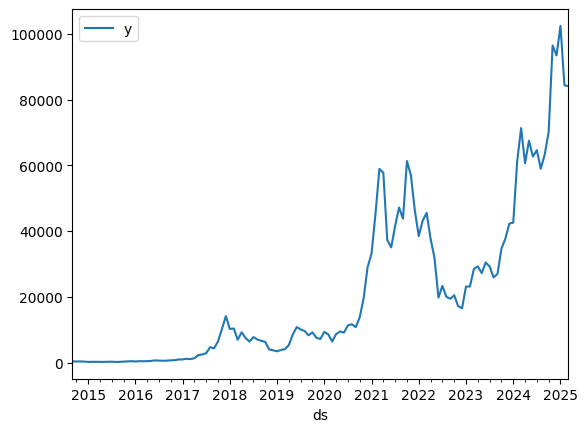

In [7]:
df.set_index('ds').plot()

# Train / Test

In [8]:
df.sort_values(by='ds', ascending=True, inplace=True)
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
train['unique_id'] = 'train'
test['unique_id'] = 'test'
print(train.shape)
print(test.shape)

(88, 3)
(39, 3)


<Axes: xlabel='ds'>

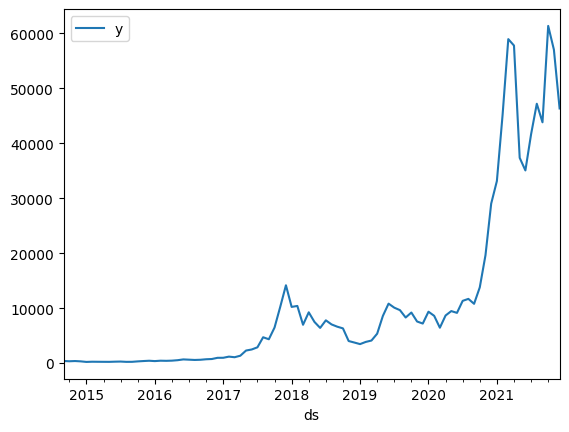

In [9]:
train.set_index('ds').plot()

# Normalization

In [10]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [11]:
train_log

,ds,y,unique_id
0,2014-09-30,5.958280,train
1,2014-10-31,5.823995,train
2,2014-11-30,5.935019,train
3,2014-12-31,5.768924,train
4,2015-01-31,5.382033,train
...,...,...,...
83,2021-08-31,10.761443,train
84,2021-09-30,10.687181,train
85,2021-10-31,11.023844,train
86,2021-11-30,10.950902,train


<Axes: xlabel='ds'>

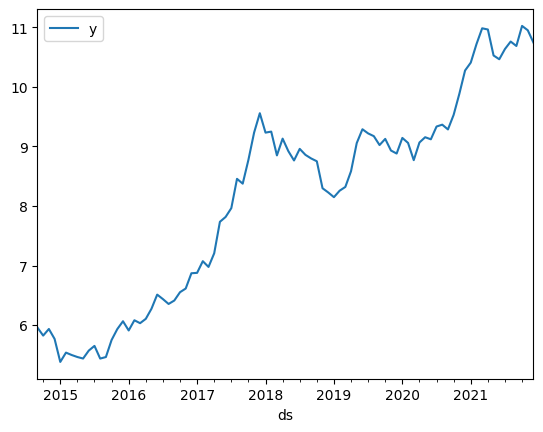

In [12]:
train_log.set_index('ds').plot()

# Correlation

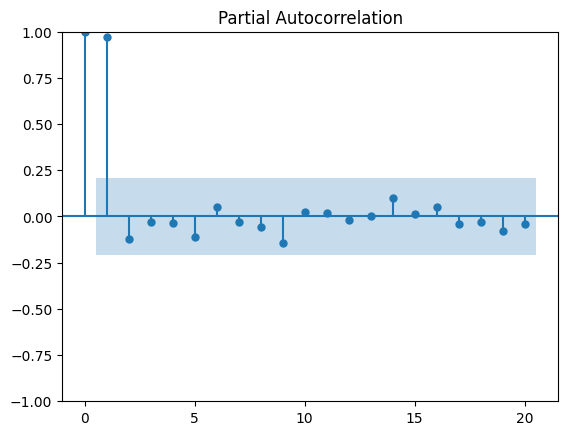

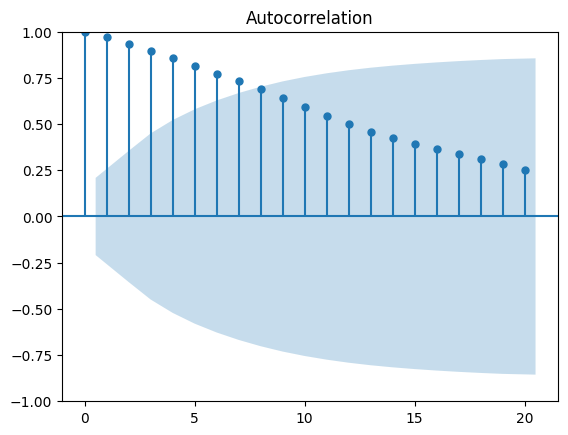

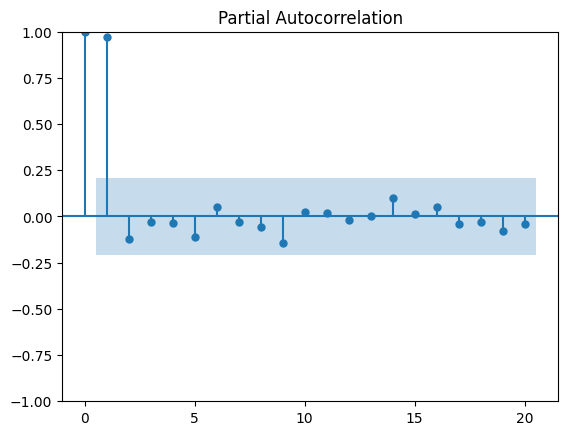

In [13]:
plot_acf(train_log['y'])
plot_pacf(train_log['y'])

# Differentiation

In [14]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

## 1ª diff

In [15]:
diff1 = train_log['y'].diff(1).dropna()
diff1


,y
1,-0.134285
2,0.111023
3,-0.166095
4,-0.386891
5,0.156336
...,...
83,0.124958
84,-0.074262
85,0.336663
86,-0.072943


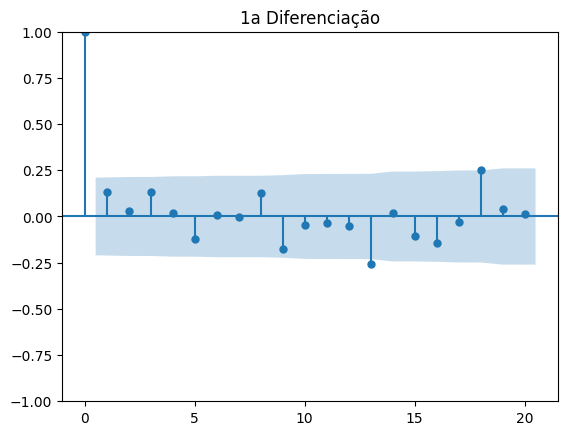

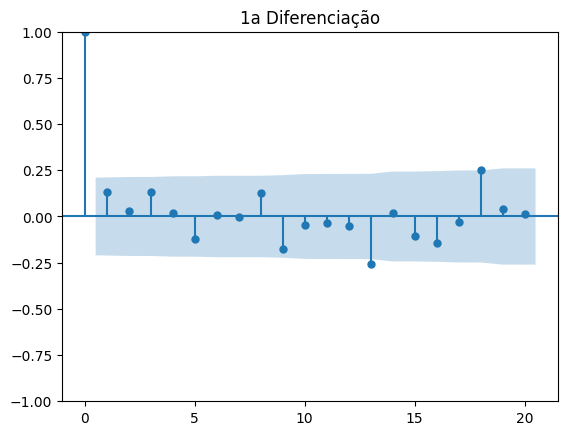

In [16]:
plot_acf(diff1, title='1a Diferenciação')

<Axes: >

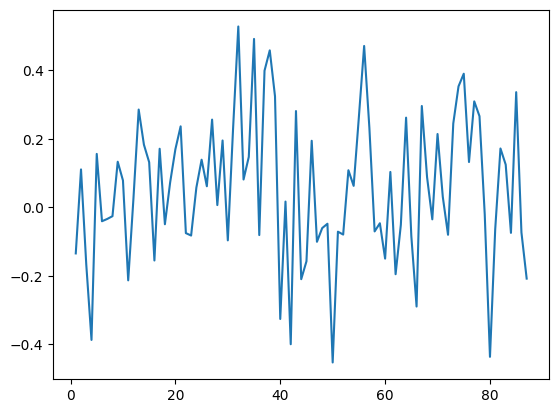

In [17]:
diff1.plot()

In [18]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.984818e+00
p-value                 2.565747e-12
# lags used             0.000000e+00
# observations          8.600000e+01
critical value (1%)    -3.508783e+00
critical value (5%)    -2.895784e+00
critical value (10%)   -2.585038e+00
Reject the null hypothesis
Data has no unit root and is stationary


## 2ª diff

In [19]:
diff2 = diff1.diff(1).dropna()
diff2


,y
2,0.245308
3,-0.277118
4,-0.220796
5,0.543226
6,-0.196619
...,...
83,-0.047257
84,-0.199220
85,0.410925
86,-0.409606


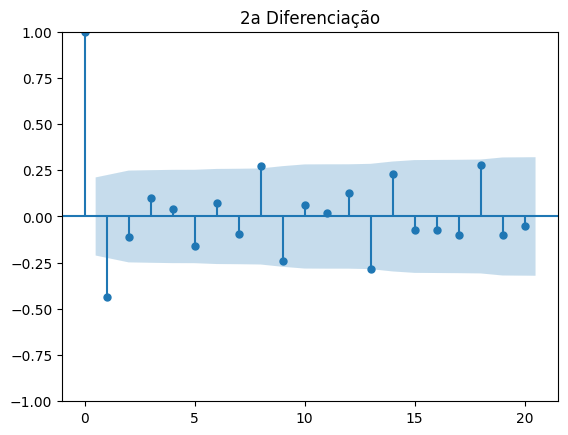

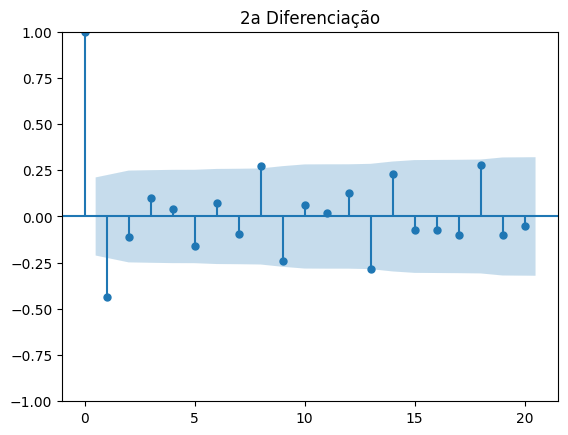

In [20]:
plot_acf(diff2, title='2a Diferenciação')

<Axes: >

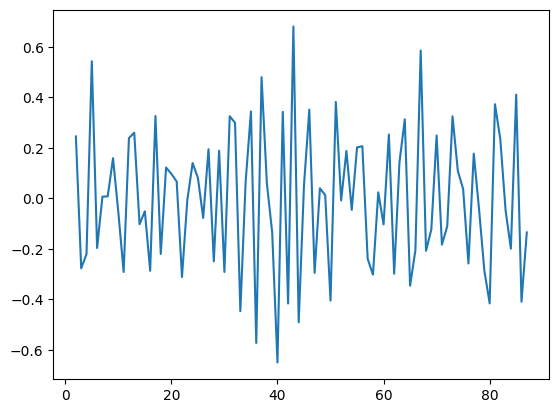

In [21]:
diff2.plot()

In [22]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.253426e+00
p-value                 4.397345e-08
# lags used             6.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
Reject the null hypothesis
Data has no unit root and is stationary


## Análise
A análise dos gráficos sugere os seguintes hiperparâmetros:

In [23]:
p = 1
d = 1
q = 0

# Modelo AR

## lag 1

In [24]:
mod1 = AutoReg(train_log['y'], p, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   88
Model:                     AutoReg(1)   Log Likelihood                  11.389
Method:               Conditional MLE   S.D. of innovations              0.212
Date:                Tue, 25 Mar 2025   AIC                            -16.779
Time:                        10:43:35   BIC                             -9.381
Sample:                             1   HQIC                           -13.800
                                   88                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0840      0.110      0.763      0.445      -0.132       0.300
y.L1           0.9964      0.013     74.962      0.000       0.970       1.022
                                    Roots           

In [25]:
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+len(test)-1
predictions1 = np.exp(res1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions'))

In [26]:
predictions1

,AR(1) Predictions
88,48464.073319
89,50713.958735
90,53059.664256
91,55504.873860
92,58053.396296
93,60709.168658
94,63476.260034
95,66358.875237
96,69361.358614
97,72488.197941


In [27]:
#Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1.iloc[i]}, expected={test['y'].iloc[i]}")

predicted=48464.073319057636, expected=38483.125
predicted=50713.95873504182, expected=43193.234375
predicted=53059.66425639736, expected=45538.67578125
predicted=55504.87385985572, expected=37714.875
predicted=58053.39629552775, expected=31792.310546875
predicted=60709.16865760724, expected=19784.7265625
predicted=63476.26003421888, expected=23336.896484375
predicted=66358.87523743209, expected=20049.763671875
predicted=69361.35861445912, expected=19431.7890625
predicted=72488.19794104216, expected=20495.7734375
predicted=75744.02839802756, expected=17168.56640625
predicted=79133.63663211247, expected=16547.49609375
predicted=82661.96490173758, expected=23139.283203125
predicted=86334.11530909057, expected=23147.353515625
predicted=90155.35411916625, expected=28478.484375
predicted=94131.11616681945, expected=29268.806640625
predicted=98267.00935273348, expected=27219.658203125
predicted=102568.81922920297, expected=30477.251953125
predicted=107042.51367662626, expected=29230.11132812

<Axes: >

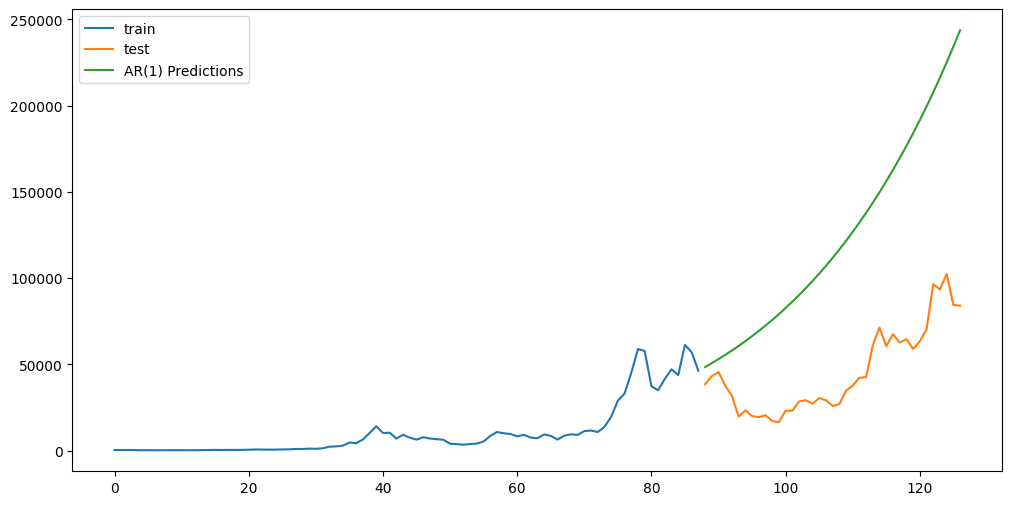

In [28]:
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
predictions1.plot(legend=True,figsize=(12,6))

# Modelo Arima

In [29]:
%%time
!pip install --upgrade scikit-learn pmdarima

CPU times: user 25.3 ms, sys: 4.37 ms, total: 29.6 ms
Wall time: 9.19 s


In [30]:

model = ARIMA(train_log['y'], order=(p,d,q))
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  10.139
Date:                Tue, 25 Mar 2025   AIC                            -16.279
Time:                        10:43:45   BIC                            -11.347
Sample:                             0   HQIC                           -14.293
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1909      0.110      1.743      0.081      -0.024       0.406
sigma2         0.0464      0.008      5.591      0.000       0.030       0.063
Ljung-Box (L1) (Q):                   0.31   Jarque-

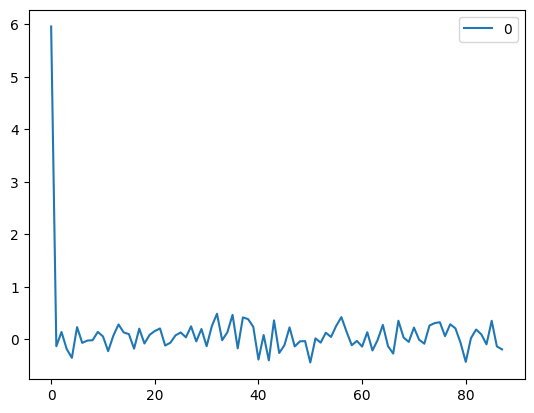

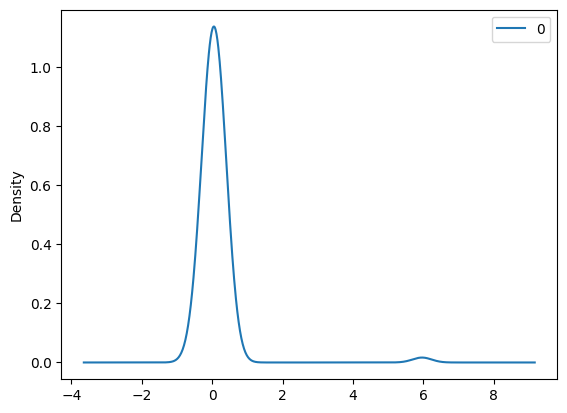

               0
count  88.000000
mean    0.111249
std     0.664759
min    -0.443653
25%    -0.102182
50%     0.047791
75%     0.210748
max     5.958280


In [31]:

# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

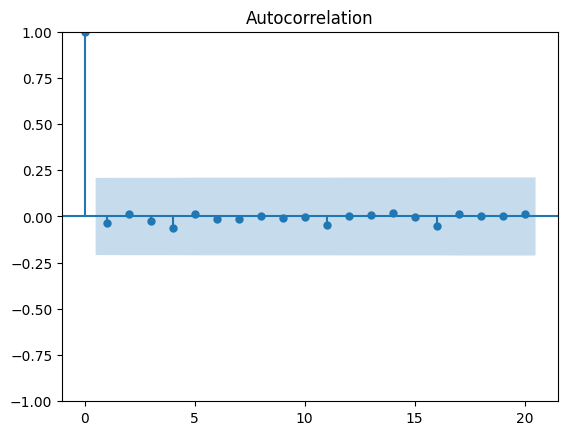

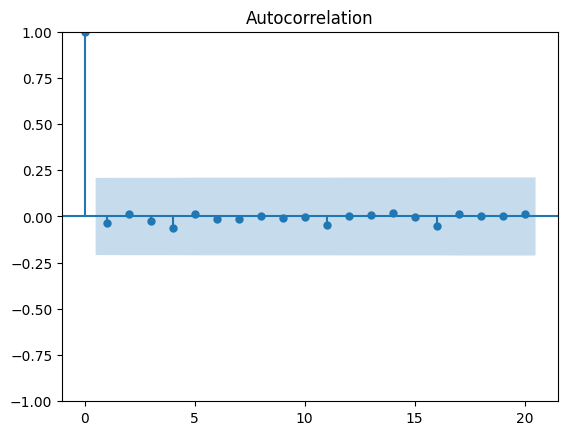

In [32]:
plot_acf(residuals)

In [33]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -30.180872
p-value                  0.000000
# lags used              0.000000
# observations          87.000000
critical value (1%)     -3.507853
critical value (5%)     -2.895382
critical value (10%)    -2.584824
Reject the null hypothesis
Data has no unit root and is stationary


In [34]:
history = train_log['y'].tolist()

predictions = list()
#walk-foward validation
test_values = test['y'].tolist()
for t in range(len(test_values)):
  model = ARIMA(history, order=(p,d,q))
  # fit model
  model_fit = model.fit()
  yhat = np.exp(model_fit.forecast()[0])
  predictions.append(yhat)
  obs = test_values[t]
  history.append(np.log(obs))
  print(f'predicted={yhat}, expected={obs}')
#evaluate forecasts
rmse = sqrt(mean_squared_error(test_values, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes

predicted=44504.84747589443, expected=38483.125
predicted=37097.98274287498, expected=43193.234375
predicted=44158.819792327544, expected=45538.67578125
predicted=46004.17744920416, expected=37714.875
predicted=36388.8228416321, expected=31792.310546875
predicted=30746.488114840253, expected=19784.7265625
predicted=17882.76528798151, expected=23336.896484375
predicted=24062.406768126508, expected=20049.763671875
predicted=19512.69879701606, expected=19431.7890625
predicted=19323.19801515429, expected=20495.7734375
predicted=20691.861939908344, expected=17168.56640625
predicted=16640.198877969575, expected=16547.49609375
predicted=16440.11413993347, expected=23139.283203125
predicted=24529.08581134395, expected=23147.353515625
predicted=23148.72483962592, expected=28478.484375
predicted=29499.243679864037, expected=29268.806640625
predicted=29404.988650673506, expected=27219.658203125
predicted=26887.50800854719, expected=30477.251953125
predicted=31059.014357107684, expected=29230.1113

In [35]:
test_array = np.array(test_values)  # Convert test_values to NumPy array
predict_array = np.array(predictions)  # Convert predictions to NumPy array

In [36]:
# Cálculo das métricas de avaliação
mse = mean_squared_error(test_array, predict_array)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_array, predict_array)
r2 = r2_score(test_array, predict_array)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test_array - predict_array) / test_array)) * 100

# Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(test_array - predict_array) /
               (np.abs(test_array) + np.abs(predict_array))) * 100

# Exibir as métricas
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")
print(f"SMAPE: {smape}")

MSE: 63214787.92072859
RMSE: 7950.772787643261
MAE: 5847.010978826341
R²: 0.8922351223947126
MAPE: 13.169820243292651
SMAPE: 13.172083881393714


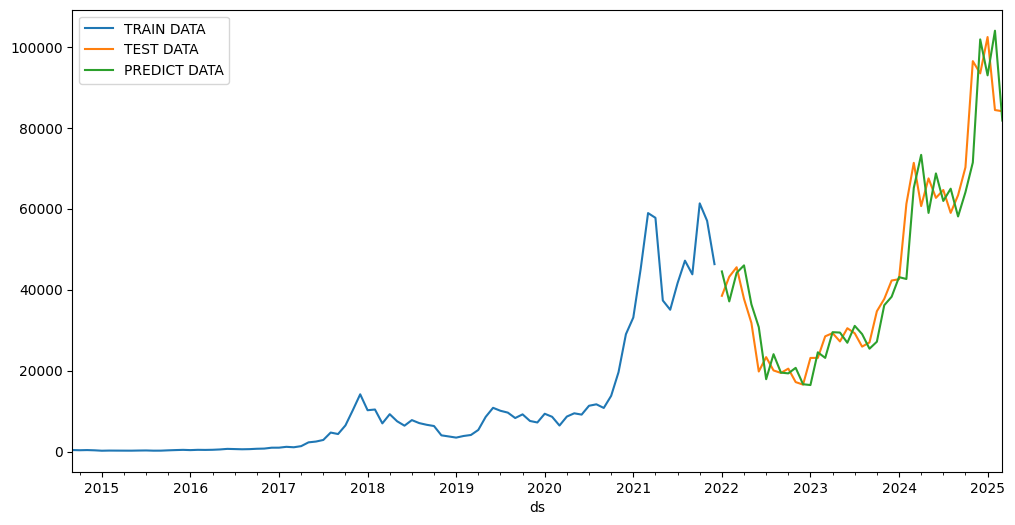

In [37]:
train.set_index('ds')['y'].plot(legend=True, label='TRAIN DATA')
test.set_index('ds')['y'].plot(legend=True, label='TEST DATA')
pd.DataFrame({'ds':test['ds'], 'y':predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICT DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)

In [38]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  22.288
Date:                Tue, 25 Mar 2025   AIC                            -40.576
Time:                        10:43:47   BIC                            -34.920
Sample:                             0   HQIC                           -38.278
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1613      0.091      1.768      0.077      -0.018       0.340
sigma2         0.0410      0.006      7.091      0.000       0.030       0.052
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.59   Prob(JB):                         0.81
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""